In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

%matplotlib inline

plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200

In [2]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.uInfMag = u_inf
        self.angle = np.deg2rad(alpha)  # degrees --> radians
        self.DragDir = np.array([np.cos(self.angle), np.sin(self.angle)])[np.newaxis,:]
        self.LiftDir = np.array([-np.sin(self.angle), np.cos(self.angle)])[np.newaxis,:]
        self.uv = self.DragDir*self.uInfMag

In [3]:
class FoilBody:
    def __init__(self, xyNodeAll,chordLength,trailingIndicator, scale=1) -> None:
        self.xyNodeAll = xyNodeAll*scale
        self.chordLen = chordLength*scale
        self.numPanel = xyNodeAll.shape[0]-1
        self.trailInd = [i%self.numPanel for i in trailingIndicator]

        self.ConverNodeAlltoAllOthers()

    def ConverNodeAlltoAllOthers(self):
        self.xyNode0 = self.xyNodeAll[:-1]
        self.xyNode1 = self.xyNodeAll[1:]
        self.xyCen = (self.xyNode0+self.xyNode1)/2

        # the tangential and normal direction
        self.xyTang = self.xyNode1 - self.xyNode0
        self.xyNorm = np.vstack((
            -self.xyTang[:,1], self.xyTang[:,0]
        )).T

        # the length
        self.panelLength = np.linalg.norm(self.xyTang, axis=1)
        self.xyTang /= self.panelLength[:,np.newaxis]
        self.xyNorm /= self.panelLength[:,np.newaxis]
        self.xyCen+=self.xyNorm*self.chordLen*0.1*0.01 # an important trick to stablize the system, offset the center a bit outside

    def Translation(self,xy):
        self.xyNodeAll += xy[np.newaxis,:]
        self.ConverNodeAlltoAllOthers()
        return self

    def MirrorY(self):
        self.xyNodeAll = np.flip(self.xyNodeAll, axis=0)
        self.xyNodeAll[:,0] = -self.xyNodeAll[:,0]
        self.ConverNodeAlltoAllOthers()
        return self
    
    def MirrorX(self):
        self.xyNodeAll = np.flip(self.xyNodeAll, axis=0)
        self.xyNodeAll[:,1] = -self.xyNodeAll[:,1]
        self.ConverNodeAlltoAllOthers()
        return self

    def rotate(self,alpha):
        alpha = np.deg2rad(alpha)
        Rot = np.array([
            [np.cos(alpha), -np.sin(alpha)],
            [np.sin(alpha),  np.cos(alpha)]
        ])
        self.xyNodeAll = (Rot@self.xyNodeAll.T).T
        self.ConverNodeAlltoAllOthers()
        return self

In [4]:
def PlotFoilVector(foils):
    fig,ax = plt.subplots(figsize=(13,4))
    for foil in foils:
        plt.quiver(foil.xyCen[:,0], foil.xyCen[:,1], foil.xyTang[:,0]*foil.panelLength, foil.xyTang[:,1]*foil.panelLength, scale_units='xy', angles='xy', scale=1,width=0.001)
        plt.quiver(foil.xyCen[:,0], foil.xyCen[:,1], foil.xyNorm[:,0]*foil.panelLength, foil.xyNorm[:,1]*foil.panelLength, scale_units='xy', angles='xy', scale=1, color="blue",width=0.001)
        plt.scatter(foil.xyCen[foil.trailInd,0],foil.xyCen[foil.trailInd,1],color=["red","darkred"],s=5)
    ax.set_aspect("equal")
    ax.set_title("Normal and tangential vector of the panel")

In [5]:
def InducedVelocityConstantSource(sigma, Target, Node0, Node1, Tang, Norm):
    eps = 1e-12
    xT = Target[:,np.newaxis,:]
    n0 = Node0[np.newaxis,:,:]
    n1 = Node1[np.newaxis,:,:]
    si = sigma[np.newaxis,:]
    tn = Tang[np.newaxis,:,:]
    nm = Norm[np.newaxis,:,:]
    th = np.arctan2(tn[:,:,1],tn[:,:,0])

    xTn0 = xT-n0
    xTn1 = xT-n1

    xTn0norm = np.linalg.norm(xTn0,axis=2)
    xTn1norm = np.linalg.norm(xTn1,axis=2)

    up = si/(2*np.pi)*(
        np.log(xTn0norm+eps) -
        np.log(xTn1norm+eps)
    )
    up = up[:,:,np.newaxis]*tn

    wp = si/(2*np.pi)*(
        (np.arctan2(xTn1[:,:,1], xTn1[:,:,0])-th)%(2*np.pi) -
        (np.arctan2(xTn0[:,:,1], xTn0[:,:,0])-th)%(2*np.pi)
    )
    wp = wp[:,:,np.newaxis]*nm

    return up+wp


In [6]:
def InducedVelocityConstantVortex(gamma, Target, Node0, Node1, Tang, Norm):
    eps = 1e-12
    xT = Target[:,np.newaxis,:]
    n0 = Node0[np.newaxis,:,:]
    n1 = Node1[np.newaxis,:,:]
    ga = gamma[np.newaxis,:]
    tn = Tang[np.newaxis,:,:]
    nm = Norm[np.newaxis,:,:]
    th = np.arctan2(tn[:,:,1],tn[:,:,0])

    xTn0 = xT-n0
    xTn1 = xT-n1

    xTn0norm = np.linalg.norm(xTn0,axis=2)
    xTn1norm = np.linalg.norm(xTn1,axis=2)

    up = ga/(2*np.pi)*(
        (np.arctan2(xTn1[:,:,1], xTn1[:,:,0])-th)%(2*np.pi) -
        (np.arctan2(xTn0[:,:,1], xTn0[:,:,0])-th)%(2*np.pi)
    )
    up = up[:,:,np.newaxis]*tn

    wp = -ga/(2*np.pi)*(
        np.log(xTn0norm+eps) -
        np.log(xTn1norm+eps)
    )
    wp = wp[:,:,np.newaxis]*nm

    return up+wp


In [13]:
def SolveStrength(foils: list[FoilBody], stream: Freestream):
    numFoil = len(foils)
    uCenSource = np.empty((numFoil,numFoil), dtype=object)
    uCenVortex = np.empty((numFoil,numFoil), dtype=object)
    ASourceN = np.empty((numFoil,numFoil), dtype=object)
    ASourceT = np.empty((numFoil,numFoil), dtype=object)
    AVortexN = np.empty((numFoil,numFoil), dtype=object)
    AVortexT = np.empty((numFoil,numFoil), dtype=object)
    bSourceN = np.empty((numFoil,), dtype=object)
    bVortexT = np.empty((numFoil,), dtype=object)
    AblockElement = np.empty((numFoil,numFoil), dtype=object)
    bblockElement = np.empty((numFoil,), dtype=object)
    numPanelList = np.zeros(numFoil)*np.nan
    for iFoilTarget, foilTarget in enumerate(foils):
        for iFoilSource, foilSource in enumerate(foils):
            uCenSource[iFoilTarget,iFoilSource] = InducedVelocityConstantSource(np.ones(foilSource.numPanel), foilTarget.xyCen, foilSource.xyNode0, foilSource.xyNode1, foilSource.xyTang, foilSource.xyNorm)
            uCenVortex[iFoilTarget,iFoilSource] = InducedVelocityConstantVortex(np.ones(foilSource.numPanel), foilTarget.xyCen, foilSource.xyNode0, foilSource.xyNode1, foilSource.xyTang, foilSource.xyNorm)

            ASourceN[iFoilTarget,iFoilSource] = np.einsum('ijk,ik->ij', uCenSource[iFoilTarget,iFoilSource], foilTarget.xyNorm)
            ASourceT[iFoilTarget,iFoilSource] = np.einsum('ijk,ik->ij', uCenSource[iFoilTarget,iFoilSource], foilTarget.xyTang)
            AVortexN[iFoilTarget,iFoilSource] = np.einsum('ijk,ik->ij', uCenVortex[iFoilTarget,iFoilSource], foilTarget.xyNorm)
            AVortexT[iFoilTarget,iFoilSource] = np.einsum('ijk,ik->ij', uCenVortex[iFoilTarget,iFoilSource], foilTarget.xyTang)

            np.fill_diagonal(ASourceN[iFoilTarget,iFoilSource],0.5)
            np.fill_diagonal(ASourceT[iFoilTarget,iFoilSource],0.0)
            np.fill_diagonal(AVortexN[iFoilTarget,iFoilSource],0.0)
            np.fill_diagonal(AVortexT[iFoilTarget,iFoilSource],0.5)

            AblockElement[iFoilTarget,iFoilSource] = np.block([
                [ASourceN[iFoilTarget,iFoilSource], np.sum(AVortexN[iFoilTarget,iFoilSource], axis=1, keepdims=True)],
                [np.sum(ASourceT[iFoilTarget,iFoilSource][foilTarget.trailInd,:],axis=0,keepdims=True),np.sum(AVortexT[iFoilTarget,iFoilSource][foilTarget.trailInd,:],keepdims=True)]
            ])

        bSourceN[iFoilTarget] = -np.einsum('ij,ij->i', foilTarget.xyNorm, stream.uv)
        bVortexT[iFoilTarget] = -np.einsum('ij,ij->i', foilTarget.xyTang, stream.uv)

        bblockElement[iFoilTarget] = np.hstack((
            bSourceN, np.sum(bVortexT[iFoilTarget][foilTarget.trailInd])
        ))

        numPanelList[iFoilTarget] = foilTarget.numPanel

    endPanelIndex = np.add.accumulate(numPanelList+1)

    AwithLift = np.block(AblockElement)
    bWithLift = np.hstack(bblockElement)

    print(AwithLift)
    print(AwithLift[1,1].shape)
    print(bWithLift.shape)

    strength = np.split(np.linalg.solve(AwithLift,bWithLift),endPanelIndex)

    

    for iFoil, foil in enumerate(foils):
        print("The dimensionless flux into FOIL {} is {:.5e}.".format(iFoil, np.sum(strength[iFoil][:-1]*foil.panelLength)/np.sum(foil.panelLength)/stream.uInfMag))

    return uCenSource, uCenVortex, strength

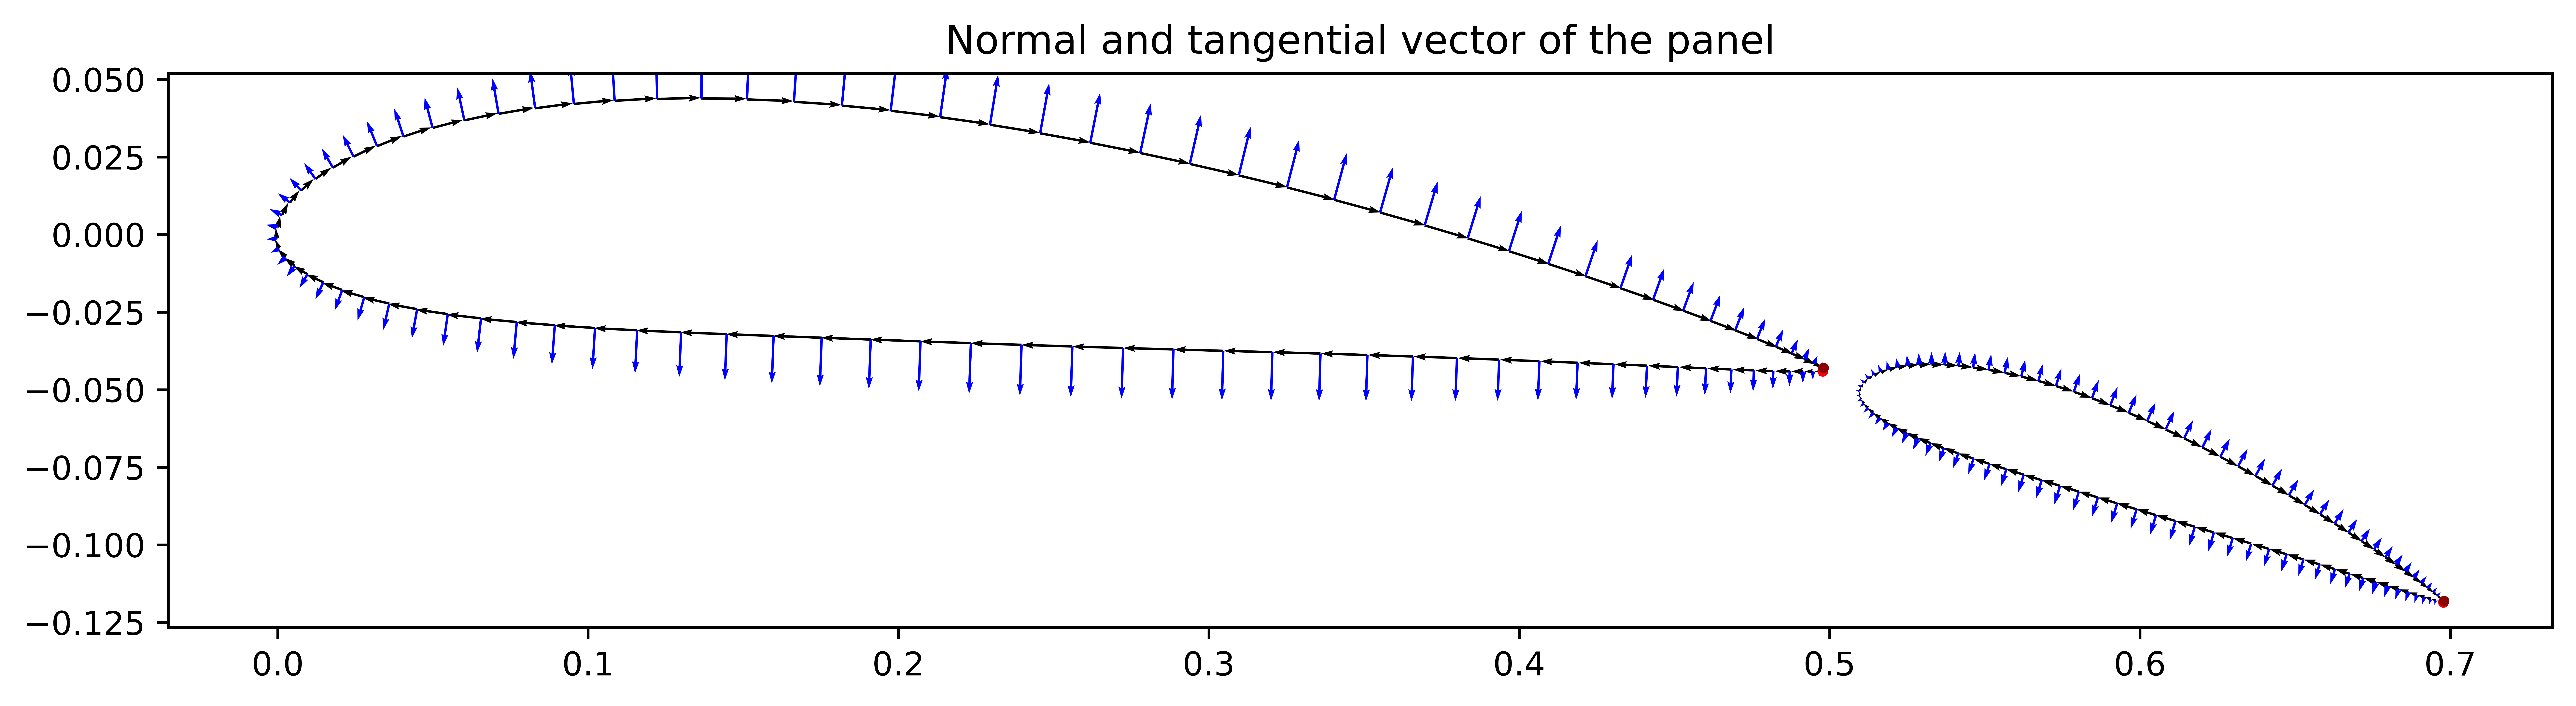

In [9]:
xyNode = np.flip(np.loadtxt("seligNACA4415.txt", skiprows=1),axis=0)
chordLen = 1
naca4415 = FoilBody(xyNode, chordLen, [0,-1], scale=0.5).rotate(-5)
naca4415_2 = FoilBody(xyNode, chordLen, [0,-1], scale=0.2).rotate(-20).Translation(np.array([0.51,-0.05]))

foilGroup = [naca4415,naca4415_2]

PlotFoilVector(foilGroup)

In [14]:
freestream = Freestream(1,5)
uCenSource, uCenVortex, strength = SolveStrength(foilGroup, freestream)

[[ 5.00000000e-01  1.30547268e-01  2.47859807e-02 ... -1.84655068e-04
  -6.15420002e-05 -8.72131926e-01]
 [ 3.17278295e-02  5.00000000e-01  6.58999255e-02 ... -1.80002330e-04
  -5.99946968e-05 -8.55165587e-01]
 [ 4.10970001e-03  3.02805041e-02  5.00000000e-01 ... -1.75383476e-04
  -5.84586367e-05 -8.21278801e-01]
 ...
 [ 1.34874539e-04  4.04507328e-04  6.71747656e-04 ...  5.00000000e-01
   3.05310104e-02 -1.61176120e+00]
 [ 1.34333147e-04  4.02892236e-04  6.69093700e-04 ...  1.28494374e-01
   5.00000000e-01 -1.95192138e+00]
 [ 3.77546576e-04 -6.28863058e-05 -1.06518936e-04 ...  8.63605735e-02
   9.33837721e-03  2.75812251e+00]]
()
(6,)


ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 6 is different from 194)

In [ ]:
Nx, Ny = 100,100
xMat, yMat = np.meshgrid(np.linspace(-0.5,1.5,Nx),np.linspace(-0.25,0.25,Ny),indexing="ij")
xList, yList = xMat.flatten(), yMat.flatten()
uvPlot = np.sum(
    InducedVelocityConstantSource(strength[:-1], np.vstack((xList,yList)).T, naca4415.xyNode0, naca4415.xyNode1, naca4415.xyTang, naca4415.xyNorm) +
    InducedVelocityConstantVortex(strength[-1]*np.ones(naca4415.numPanel), np.vstack((xList,yList)).T, naca4415.xyNode0, naca4415.xyNode1, naca4415.xyTang, naca4415.xyNorm), axis=1
) + freestream.uv


In [ ]:
# aa = 2/np.sqrt(5)
# bb = 1/np.sqrt(5)
# uvPlot = np.sum(
#     InducedVelocityConstantVortex(np.array([1,1]), np.vstack((xList,yList)).T,np.array([[0.2,0.1],[0,0]]),np.array([[0,0],[0.2,0.1]]), np.array([[-aa,-bb],[aa,bb]]), np.array([[bb,-aa],[-bb,aa]])), axis=1
# )

In [ ]:
uPlot = uvPlot[:,0].reshape(xMat.shape)
vPlot = uvPlot[:,1].reshape(xMat.shape)

fig,ax = plt.subplots(figsize=(13,10))
ax.plot(naca4415.xyCen[:,0],naca4415.xyCen[:,1], color="black")
#ax.plot([0,0.2], [0,0.1], color="black")
cf = ax.contourf(xMat,yMat,np.sqrt(uPlot**2+vPlot**2), levels=100,cmap="gist_ncar")
ax.streamplot(xMat.T, yMat.T, uPlot.T, vPlot.T, density=3, linewidth=0.5, color="blue")
ax.set_aspect("equal")
ax.set_xlim((-0.55,1.55))
ax.set_ylim((-0.3,0.3))
ax.set_title("Velocity Vectors and Pressure Coefficient")
plt.colorbar(cf,location="bottom")

In [ ]:
velOnPanel = np.einsum("ijk,j->ik",uCenSource,strength[:-1]) + np.einsum("ijk,j->ik",uCenVortex,strength[-1]*np.ones(naca4415.numPanel)) + freestream.uv
presCoeffOnPanel = 1 - (np.linalg.norm(velOnPanel, axis=1)/freestream.uInfMag)**2
ForceCoeff = np.sum(-naca4415.xyNorm*presCoeffOnPanel[:,np.newaxis]*naca4415.panelLength[:,np.newaxis], axis=0)/naca4415.chordLen
DragCoeff = np.dot(ForceCoeff,freestream.DragDir.flatten())
LiftCoeff = np.dot(ForceCoeff,freestream.LiftDir.flatten())

In [ ]:
fig,ax = plt.subplots()
ax.plot(naca4415.xyCen[:,0],presCoeffOnPanel, ".-b")
ax.plot(naca4415.xyCen[:,0],-naca4415.xyCen[:,1]*3, color="black")
ax.invert_yaxis()
ax.set_aspect("auto")